<h3 style="color:darkblue;">👁️Practical Drowsiness Detection System Using Computer Vision and Eye Aspect Ratio</h3>

<h4 style="color:darkred;">Install Packages and Import Libraries</h4>

In [2]:
# Download and installl this package in your working directory
!pip install dlib-19.24.99-cp312-cp312-win_amd64.whl

Processing c:\users\user\desktop\projects\data science\computer vision\dlib-19.24.99-cp312-cp312-win_amd64.whl
dlib is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [4]:
# Install packages needed
!pip install dlib imutils playsound -q

In [1]:
# Imports libraries
import cv2
import dlib
import time
import datetime
import csv
import os
from scipy.spatial import distance as dist
from threading import Thread
from playsound import playsound
import winsound

<h4 style="color:darkred;">Download and Load Facial Landmark Detection Model (Dlib 68-point)</h4>

In [2]:
import urllib.request
import bz2
import shutil

# Download the compressed file
url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
filename = "shape_predictor_68_face_landmarks.dat.bz2"
urllib.request.urlretrieve(url, filename)

# Extract the .bz2 file
with bz2.open(filename, "rb") as f_in:
    with open("shape_predictor_68_face_landmarks.dat", "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

print("Model downloaded and extracted successfully!")

Model downloaded and extracted successfully!


In [3]:
# Load Dlib's face detector (HOG-based) and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

<h4 style="color:darkblue;">Compute Eye Aspect Ratio (EAR)</h4>

In [4]:
# Define Eye Aspect Ratio (EAR) Calculation
def eye_aspect_ratio(eye):
    # Compute the euclidean distances between the vertical eye landmarks
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])

    # Compute the euclidean distance between the horizontal eye landmarks
    C = dist.euclidean(eye[0], eye[3])

    # EAR calculation
    ear = (A + B) / (2.0 * C)
    return ear

<h4 style="color:darkblue;">Initialize webcam</h4>

In [5]:
# Initialize webcam
cap = cv2.VideoCapture(0)

# Check if webcam opened successfully
if not cap.isOpened():
   print("Error: Could not open webcam")
   exit()
else:
   print("Camera initialized successfully!")

# Set frame dimensions
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
print("System ready. Press 'q' to quit when running.")

Camera initialized successfully!
System ready. Press 'q' to quit when running.


<h4 style="color:darkblue;">Real-Time Detection</h4>

In [6]:
alarm_on = False  # global flag to control looping alarm

# Play alert sound
def play_alert():
    global alarm_on
    try:
        while alarm_on:
            if os.path.exists("alert.wav"):
                winsound.PlaySound('alert.wav', winsound.SND_FILENAME | winsound.SND_ASYNC)
                time.sleep(0.3)
            else:
                # fallback beep
                winsound.Beep(1000, 300)
                time.sleep(0.2)
    except Exception:
        pass

# CSV logging setup
log_filename = f"drowsiness_log_{datetime.datetime.now().strftime('%Y%m%d')}.csv"
log_exists = os.path.exists(log_filename)
if not log_exists:
    with open(log_filename, 'w', newline='') as logfile:
        writer = csv.writer(logfile)
        writer.writerow(['Timestamp', 'Event', 'EAR_Value', 'Duration_Seconds'])

# Video recording setup
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_filename = f"drowsiness_session_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.mp4"
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter(out_filename, fourcc, 20.0, (frame_width, frame_height))

# Drowsiness parameters
EAR_THRESHOLD = 0.25
CONSECUTIVE_FRAMES = 20

# Initialize counters and logging
frame_counter = 0
drowsy_flag = False
total_frames = 0
drowsy_episodes = 0
start_time = time.time()
drowsy_start_time = 0

# Eye landmark indices
LEFT_EYE_IDX = list(range(36, 42))
RIGHT_EYE_IDX = list(range(42, 48))

print("Starting drowsiness detection...")
print("Press 'q' to quit")

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        total_frames += 1
        frame_height, frame_width = frame.shape[:2]
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray, 0)

        for face in faces:
            landmarks = predictor(gray, face)

            # Face bounding box
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Eye coordinates
            left_eye = [(landmarks.part(i).x, landmarks.part(i).y) for i in LEFT_EYE_IDX]
            right_eye = [(landmarks.part(i).x, landmarks.part(i).y) for i in RIGHT_EYE_IDX]

            for (ex, ey) in left_eye + right_eye:
                cv2.circle(frame, (ex, ey), 1, (0, 255, 0), -1)

            # EAR calculation
            left_ear = eye_aspect_ratio(left_eye)
            right_ear = eye_aspect_ratio(right_eye)
            avg_ear = (left_ear + right_ear) / 2.0

            # Check if EAR is below threshold
            if avg_ear < EAR_THRESHOLD:
                frame_counter += 1
                if frame_counter >= CONSECUTIVE_FRAMES:
                    if not drowsy_flag:
                        drowsy_flag = True
                        drowsy_episodes += 1
                        drowsy_start_time = time.time()
                        # Log drowsiness start
                        with open(log_filename, 'a', newline='') as logfile:
                            writer = csv.writer(logfile)
                            writer.writerow([datetime.datetime.now(), 'Drowsiness_Start', f'{avg_ear:.3f}', ''])
                        # Start continuous alarm thread
                        if not alarm_on:
                            alarm_on = True
                            Thread(target=play_alert, daemon=True).start()
                            print(f"[ALERT] Drowsy episode #{drowsy_episodes} started at {datetime.datetime.now().strftime('%H:%M:%S')}")
            else:
                if drowsy_flag:
                    # Log drowsiness end
                    drowsy_duration = time.time() - drowsy_start_time
                    with open(log_filename, 'a', newline='') as logfile:
                        writer = csv.writer(logfile)
                        writer.writerow([datetime.datetime.now(), 'Drowsiness_End', f'{avg_ear:.3f}', f'{drowsy_duration:.1f}'])
                    print(f"[INFO] Drowsy episode #{drowsy_episodes} ended at {datetime.datetime.now().strftime('%H:%M:%S')} (duration: {drowsy_duration:.1f}s)")
                frame_counter = 0
                drowsy_flag = False
                # Stop alarm
                if alarm_on:
                    alarm_on = False
                    # Purge any async PlaySound
                    try:
                        winsound.PlaySound(None, winsound.SND_PURGE)
                    except Exception:
                        pass

        # status panel - bottom left
        panel_width, panel_height = 230, 110
        panel_x, panel_y = 10, frame_height - panel_height - 10

        # Semi-transparent background
        overlay = frame.copy()
        cv2.rectangle(overlay, (panel_x, panel_y), (panel_x + panel_width, panel_y + panel_height), (0, 0, 0), -1)
        cv2.addWeighted(overlay, 0.7, frame, 0.3, 0, frame)
        cv2.rectangle(frame, (panel_x, panel_y), (panel_x + panel_width, panel_y + panel_height), (255, 255, 255), 1)

        # Display information in panel
        if len(faces) > 0:
            cv2.putText(frame, f"Left EAR: {left_ear:.3f}", (panel_x + 10, panel_y + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
            cv2.putText(frame, f"Right EAR: {right_ear:.3f}", (panel_x + 10, panel_y + 35), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
            cv2.putText(frame, f"Avg EAR: {avg_ear:.3f}", (panel_x + 10, panel_y + 50), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)
            cv2.putText(frame, f"Threshold: {EAR_THRESHOLD}", (panel_x + 10, panel_y + 70), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
            cv2.putText(frame, f"Frames: {frame_counter}/{CONSECUTIVE_FRAMES}", (panel_x + 10, panel_y + 85), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
        else:
            cv2.putText(frame, "No Face Detected", (panel_x + 10, panel_y + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

        # Session info
        elapsed_time = int(time.time() - start_time)
        cv2.putText(frame, f"Time: {elapsed_time}s | Episodes: {drowsy_episodes}", (panel_x + 10, panel_y + 105), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (200, 200, 200), 1)

        # Top right status indicator
        status_x, status_y = frame_width - 120, 20
        if len(faces) > 0:
            status_color = (0, 0, 255) if drowsy_flag else (0, 255, 0)
            status_text = "DROWSY" if drowsy_flag else "ALERT"
            cv2.circle(frame, (status_x + 80, status_y + 10), 12, status_color, -1)
            cv2.putText(frame, status_text, (status_x, status_y + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, status_color, 2)

        # Top left drowsiness alert
        if drowsy_flag:
            alert_width, alert_height = 270, 50
            alert_x, alert_y = 10, 20
            overlay = frame.copy()
            cv2.rectangle(overlay, (alert_x, alert_y), (alert_x + alert_width, alert_y + alert_height), (0, 0, 255), -1)
            cv2.addWeighted(overlay, 0.8, frame, 0.2, 0, frame)
            cv2.putText(frame, "DROWSINESS ALERT!", (alert_x + 20, alert_y + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            cv2.putText(frame, "WAKE UP NOW!", (alert_x + 60, alert_y + 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        # Display window
        cv2.imshow("Drowsiness Detection System", frame)

        # Save processed frame to video
        out.write(frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

except KeyboardInterrupt:
    pass
finally:
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    # ensure alarm stopped
    alarm_on = False
    try:
        winsound.PlaySound(None, winsound.SND_PURGE)
    except Exception:
        pass

    print("\nSession Summary:")
    print(f"Total time: {int(time.time() - start_time)} seconds")
    print(f"Total frames processed: {total_frames}")
    print(f"Drowsy episodes detected: {drowsy_episodes}")
    print(f"Log file saved: {log_filename}")
    print(f"Video file saved: {out_filename}")
    print("System shutdown complete.")

Starting drowsiness detection...
Press 'q' to quit
[ALERT] Drowsy episode #1 started at 22:16:38
[INFO] Drowsy episode #1 ended at 22:16:40 (duration: 2.0s)
[ALERT] Drowsy episode #2 started at 22:16:42
[INFO] Drowsy episode #2 ended at 22:16:46 (duration: 4.0s)
[ALERT] Drowsy episode #3 started at 22:16:50
[INFO] Drowsy episode #3 ended at 22:16:52 (duration: 2.8s)
[ALERT] Drowsy episode #4 started at 22:16:55
[INFO] Drowsy episode #4 ended at 22:16:56 (duration: 0.7s)
[ALERT] Drowsy episode #5 started at 22:16:58
[INFO] Drowsy episode #5 ended at 22:16:59 (duration: 0.8s)
[ALERT] Drowsy episode #6 started at 22:17:00

Session Summary:
Total time: 26 seconds
Total frames processed: 482
Drowsy episodes detected: 6
Log file saved: drowsiness_log_20250928.csv
Video file saved: drowsiness_session_20250928_221634.mp4
System shutdown complete.


In [ ]:
# Note: File changed from .avi to .mp4

<h4 style="color:darkblue;">Drowsiness Log Analyzer</h4>

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data & Print Basic Info
log_filename = "drowsiness_log_20250915.csv"  # Note: change file name to match as saved in the session summary
df = pd.read_csv(log_filename, parse_dates=['Timestamp'])

print(df.head())
print("\nTotal records:", len(df))
print("Unique Events:", df['Event'].unique())
print("Total drowsy episodes:", (df['Event'] == 'Drowsiness_Start').sum())

# Create duration column (fill 0 for NaN)
df['Duration_Seconds'] = pd.to_numeric(df['Duration_Seconds'], errors='coerce').fillna(0)

                   Timestamp             Event  EAR_Value  Duration_Seconds
0 2025-09-15 22:27:40.318714  Drowsiness_Start      0.233               NaN
1 2025-09-15 22:27:41.937682    Drowsiness_End      0.288               1.6
2 2025-09-15 22:27:46.904916  Drowsiness_Start      0.183               NaN
3 2025-09-15 22:27:50.276836    Drowsiness_End      0.261               3.4
4 2025-09-15 22:27:55.541796  Drowsiness_Start      0.162               NaN

Total records: 32
Unique Events: ['Drowsiness_Start' 'Drowsiness_End']
Total drowsy episodes: 16


In [106]:
# Check actual session duration
start_time = df['Timestamp'].min()
end_time = df['Timestamp'].max()
total_duration = (end_time - start_time).total_seconds() / 60

print(f"Session started: {start_time}")
print(f"Session ended: {end_time}")
print(f"Total session time: {total_duration:.1f} minutes")

Session started: 2025-09-15 22:27:40.318714
Session ended: 2025-09-15 22:29:39.236415
Total session time: 2.0 minutes


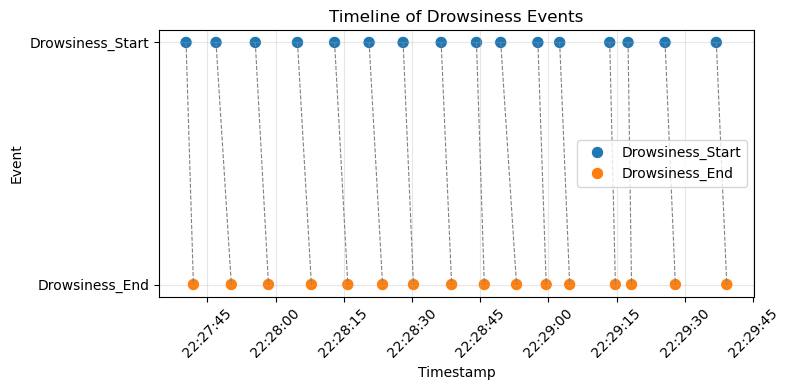

In [107]:
# Episode Timeline Visual
plt.figure(figsize=(8,4))
plt.grid(True, alpha=0.3)
sns.scatterplot(data=df[df['Event'].isin(['Drowsiness_Start','Drowsiness_End'])],
                x='Timestamp', y='Event', hue='Event', s=80)

# Vertical lines between the start and end events
for i in range(0, len(df)-1, 2):
    if df.iloc[i]['Event'] == 'Drowsiness_Start' and df.iloc[i+1]['Event'] == 'Drowsiness_End':
        plt.plot([df.iloc[i]['Timestamp'], df.iloc[i+1]['Timestamp']], ['Drowsiness_Start', 'Drowsiness_End'],
                 color='gray', linestyle='--', linewidth=0.8)

plt.title("Timeline of Drowsiness Events")
plt.xticks(rotation=45)
plt.legend(loc='center right')
plt.tight_layout()
plt.show()

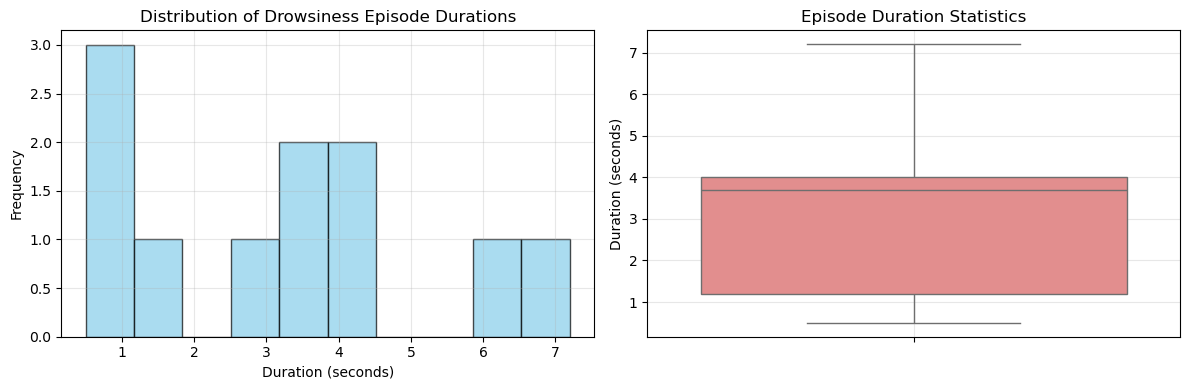

In [108]:
# Duration Analysis Visual
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

# Histogram of durations
plt.hist(duration_data['Duration_Seconds'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Drowsiness Episode Durations")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
    
# Box plot of durations
plt.subplot(1, 2, 2)
sns.boxplot(y=duration_data['Duration_Seconds'], color='lightcoral')
plt.title("Episode Duration Statistics")
plt.ylabel('Duration (seconds)')
plt.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

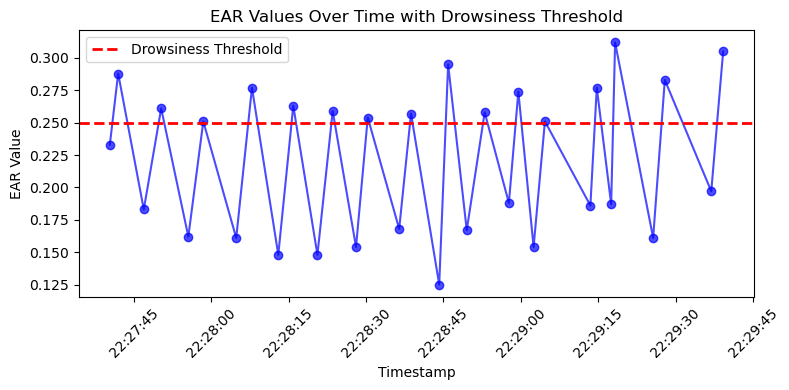

EAR below threshold: 11 readings
Percentage below threshold: 50.0%


In [109]:
# EAR Trends Visual
plt.figure(figsize=(8, 4))
plt.plot(df['Timestamp'], df['EAR_Value'], marker='o', linestyle='-', color='blue', alpha=0.7)
plt.axhline(y=0.25, color='red', linestyle='--', linewidth=2, label='Drowsiness Threshold')
plt.title('EAR Values Over Time with Drowsiness Threshold')
plt.xlabel('Timestamp')
plt.ylabel('EAR Value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(f"EAR below threshold: {(ear_data['EAR_Value'] < 0.25).sum()} readings")
print(f"Percentage below threshold: {(ear_data['EAR_Value'] < 0.25).mean()*100:.1f}%")

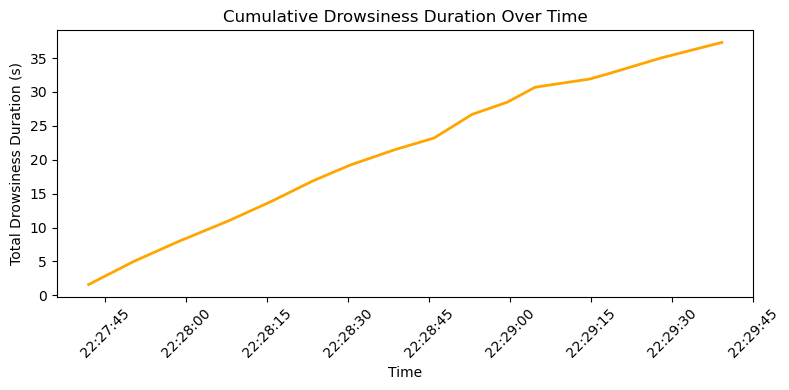

In [110]:
# Cumulative Drowsiness
df['Cumulative_Duration'] = df['Duration_Seconds'].cumsum()
df_end = df[df['Event'] == 'Drowsiness_End']

plt.figure(figsize=(8, 4))
plt.plot(df_end['Timestamp'], df_end['Cumulative_Duration'], color='orange', linewidth=2)
plt.title("Cumulative Drowsiness Duration Over Time")
plt.xlabel("Time")
plt.ylabel("Total Drowsiness Duration (s)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

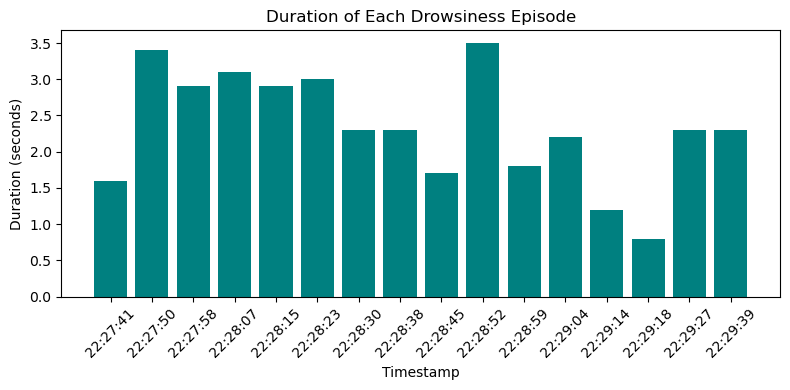

Total Drowsiness Duration: 37.3 seconds
Number of Drowsiness Episodes: 16
Average Episode Duration: 2.3 seconds
Longest Episode: 3.5 seconds


In [111]:
# Each Drowsiness Episode
# Filter only drowsiness end events
durations = df[df['Event'] == 'Drowsiness_End'][['Timestamp', 'Duration_Seconds']]

plt.figure(figsize=(8,4))
plt.bar(durations['Timestamp'].dt.strftime('%H:%M:%S'), durations['Duration_Seconds'], color='teal')
plt.xticks(rotation=45)
plt.xlabel('Timestamp')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Drowsiness Episode')
plt.tight_layout()
plt.show()

# Summary Print
total_duration = df_end['Duration_Seconds'].sum()
total_episodes = len(df_end)
average_duration = df_end['Duration_Seconds'].mean()
longest_episode = df_end['Duration_Seconds'].max()

print(f"Total Drowsiness Duration: {total_duration:.1f} seconds")
print(f"Number of Drowsiness Episodes: {total_episodes}")
print(f"Average Episode Duration: {average_duration:.1f} seconds")
print(f"Longest Episode: {longest_episode:.1f} seconds")